# Qiskit and OpenQASM3 to LLVM IR
Qiskit abstracts many aspects of the quantum compilation process, allowing us to interface with complex systems with a bit of simple python. To use Qiskit, a user would typically:
1. Create a quantum circuit
2. Transpile the circuit onto a backend of choice (either a simulated backend or real quantum hardware)
3. Execute the circuit on the chosen backend
4. Get the results of the executed quantum circuit.

In this tutorial, we will take an in depth look at ste 2, transpilation. We will also look at the pipeline of translating high-level  Qiskit code into OpenQASM3, and finally into IR using qcor.

It all starts with first installing the Qiskit package:

In [ ]:

pip install qiskit

In [1]:
# 1) Create a simple quantum circuit.

from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

qc = QuantumCircuit(5)
qc.h(0)
qc.cx(0,range(1,5))
qc.measure_all()
qc.draw()

┌───┐                     ░ ┌─┐            
   q_0: ┤ H ├──■────■────■────■───░─┤M├────────────
        └───┘┌─┴─┐  │    │    │   ░ └╥┘┌─┐         
   q_1: ─────┤ X ├──┼────┼────┼───░──╫─┤M├─────────
             └───┘┌─┴─┐  │    │   ░  ║ └╥┘┌─┐      
   q_2: ──────────┤ X ├──┼────┼───░──╫──╫─┤M├──────
                  └───┘┌─┴─┐  │   ░  ║  ║ └╥┘┌─┐   
   q_3: ───────────────┤ X ├──┼───░──╫──╫──╫─┤M├───
                       └───┘┌─┴─┐ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ────────────────────┤ X ├─░──╫──╫──╫──╫─┤M├
                            └───┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/═════════════════════════════╩══╩══╩══╩══╩═
                                     0  1  2  3  4

In [2]:
# 2) Transpile the circuit on a simulated noisy quantum hardware backend (more on this step later).
# For information about these "simulated noisy backends", see
# https://qiskit.org/documentation/tutorials/simulators/2_device_noise_simulation.html

from qiskit.test.mock import FakeBoeblingen
from qiskit.compiler import transpile

simulated_backend = FakeBoeblingen()
transpiled_qc = transpile(qc, simulated_backend, optimization_level=0)

In [3]:
# 3) Now, we can execute the transpiled circuit on the simulated noisy backend
results = simulated_backend.run(transpiled_qc).result()

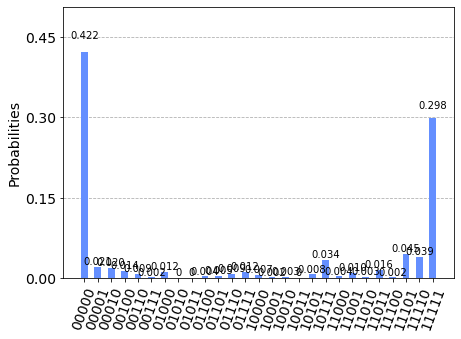

In [4]:
# 4) Finally, get the results of the executed circuit. Since our circuit entangles all the qubits,
# We should be aiming for a 50/50 split between the |00000> and |11111> states. Of course, due
# to our simulated noise we won't quite achieve that
from qiskit.tools.visualization import plot_histogram

counts = results.get_counts()
plot_histogram(counts)

In this introductory section, we simply created, transpiled, and executed a simple quantum circuit, then printed the results at the end. In the rest of this tutorial we will focus on the transpilation step, what goes on behind the scenes, why it is important to overall compilation and how it can meaningfully affect results. 

# Transpilation: What is it?

As the prefix suggests, transpilation differs from compilation in that it moves laterally, rather than vertically. While compilation normally takes in a high-level source and spits out a low level target program, transpilations input and output are of comparable complexity. In our case, the Qiskit transpiler injests one quantum circuit and spits out an optimized version of that circuit after having performed several transformative passes.

![Transpilation Passes](transpiling_core_steps.png)


Note: See [here](https://qiskit.org/documentation/apidoc/transpiler.html) For more information about the transpilation process.

###  Hardware Dependency
Earlier, we ran
```{python}
simulated_backend = FakeBoeblingen()
transpiled_qc = transpile(qc, simulated_backend, optimization_level=0)
```
Note that the transpile function takes a ``backend`` parameter. It uses this information in order to optimize the quantum circuit according to the particular hardware the quantum circuit will be running on. Therefore, the transpilation process is **"hardware aware"**.

### What Other Parameters Does `transpile()` Take?
The `transpile()` function has another parameter called `optimization_level`, which specifies a predefined transpilation process, or a predefined sequence of transformative passes. As shown earlier, the transpilation process involves gate optimization, device connectivity optimization, and more - in fact, it's a somewhat daunting list. Again, Qiskit abstracts these concepts away and allows a quantum programmer to use one of four predefined transpilation processes without fiddling with the details. By default `optimization_level = 1`, but we can set it to four different values as shown here:
```{python}
simulated_backend = FakeBoeblingen()
transpiled_qc0 = transpile(qc, simulated_backend, optimization_level=0)  # No Optimization
transpiled_qc1 = transpile(qc, simulated_backend, optimization_level=1)  # Some Optimization
transpiled_qc2 = transpile(qc, simulated_backend, optimization_level=2)  # More Optimization
transpiled_qc3 = transpile(qc, simulated_backend, optimization_level=3)  # Maximum Optimization
```

Note: See [here](https://qiskit.org/documentation/stubs/qiskit.compiler.transpile.html) for more information about the `traspiler()` parameters.

These optimizations do work - even with this very simple circuit which doesn't have much room for optimization, you should be able to see a bump in the percentages of the desired answers.

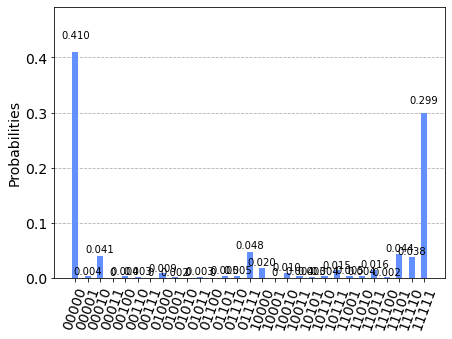

In [5]:
# 2) Lets transpile our previous circuit again using the most advanced predefined transpilation process, optimization_level=3
transpiled_qc3 = transpile(qc, simulated_backend, optimization_level=3)

# 3) Lets execute the transpiled circuit on the simulated noisy backend
results = simulated_backend.run(transpiled_qc3).result()

# 4) Lets get the results of the executed circuit
counts = results.get_counts()
plot_histogram(counts)

As you can see, in general you will find that the transpiled circuit using optimization_level=3 produces more accurate probabilities than a transpiled circuit using optimization_level=0.

# Example 1: Bernstein-Vazirani Circuit for 3 bit hidden string s
Here we will go over a small circuit that implements the BV algorithm for a 3 bit hidden string s.

In [6]:
### Lets defined a new circuit of your choice with no measurements

s = '011'   # the hidden binary string
n = 3 # number of bits used to represent s


# We need a circuit with n qubits, plus one auxiliary qubit
# We also need n classical bits to write the output to
qc = QuantumCircuit(n+1, n)

# Put auxiliary in the minus state |->
# We leave the other n qubits in just |0>
qc.h(n)
qc.z(n)

# Apply Hadamard gates to each of the n "main" qubits (excluding the auxiliary)
# before querying the oracle
for i in range(n):
    qc.h(i)
    
# Apply barrier
qc.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        qc.i(q)
    else:
        qc.cx(q, n)
        
# Apply barrier
qc.barrier()

# Apply Hadamard gates after querying the oracle
for i in range(n):
    qc.h(i)


# Measurement
for i in range(n):
    qc.measure(i, i)


qc.draw()

┌───┐      ░                 ░ ┌───┐┌─┐      
q_0: ┤ H ├──────░───■─────────────░─┤ H ├┤M├──────
     ├───┤      ░   │             ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├──────░───┼─────────■───░─┤ H ├─╫─┤M├───
     ├───┤      ░   │  ┌───┐  │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├──────░───┼──┤ I ├──┼───░─┤ H ├─╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐└───┘┌─┴─┐ ░ └───┘ ║  ║ └╥┘
q_3: ┤ H ├┤ Z ├─░─┤ X ├─────┤ X ├─░───────╫──╫──╫─
     └───┘└───┘ ░ └───┘     └───┘ ░       ║  ║  ║ 
c: 3/═════════════════════════════════════╩══╩══╩═
                                          0  1  2

### Choice of Backend
Here we will be using the `FakeBoeblingen()` backend.
For more information about Qiskit's backends, please visit:
1) [Backend Tutorial](https://qiskit.org/documentation/tutorials/circuits_advanced/08_gathering_system_information.html)
2) [Backend Config](https://qiskit.org/documentation/stubs/qiskit.providers.models.BackendConfiguration.html#qiskit.providers.models.BackendConfiguration)

In [7]:
# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()


# Print out basic features of this backend. Note, I am using a function found in Backend_Resource2
config = simulated_backend.configuration()
print("This backend is called {0}, and is on version {1}. \nIt has {2} qubit{3}. \nIt "
      "{4} OpenPulse programs. \nThe basis gates supported on this device are {5}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates))

This backend is called fake_boeblingen, and is on version 1.2.9. 
It has 20 qubits. 
It supports OpenPulse programs. 
The basis gates supported on this device are ['id', 'u1', 'u2', 'u3', 'cx'].


### Logger
Used to print out the passes used for `optimization_level`. Passes are printed out after using `transpile()`

In [8]:
import logging

logging.basicConfig(level='DEBUG')
logging.getLogger('qiskit.transpiler').setLevel('INFO')
formatter = logging.Formatter('%(asctime)s --- %(name)s --- %(levelname)s: %(message)s\n')
handler = logging.getLogger().handlers[0]
handler.setFormatter(formatter)

### No Optimization
If we set `optimization_level = 0`, the transpiler will do no optimization, so we end up running our input circuit on hardware exactly as its been defined. This will usually give bad results, because your circuit does not even consider basic factors like device connectivity, there is no reduction of swap gates, etc.

In [9]:
transpiled_qc0 = transpile(qc, simulated_backend, optimization_level=0)  # No Optimization
print('Optimization Level 0')
print('Depth:', transpiled_qc0.depth())
print('Gate counts:', transpiled_qc0.count_ops())
transpiled_qc0.draw()

2022-06-24 18:17:57,969 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='aqc', value='qiskit.transpiler.synthesis.aqc.aqc_plugin:AQCSynthesisPlugin', group='qiskit.unitary_synthesis')

2022-06-24 18:17:57,970 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.passes.synthesis.unitary_synthesis:DefaultUnitarySynthesis', group='qiskit.unitary_synthesis')

2022-06-24 18:17:57,970 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='aqc', value='qiskit.transpiler.synthesis.aqc.aqc_plugin:AQCSynthesisPlugin', group='qiskit.unitary_synthesis')

2022-06-24 18:17:57,971 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.passes.synthesis.unitary_synthesis:DefaultUnitarySynthesis', group='qiskit.unitary_synthesis')

2022-06-24 18:17:57,972 --- qiskit.transpiler.runningpassmanager --- INFO: Pass: SetLayout - 0.00000 (ms)

2022-06-24 18:17:57,973 --- qiskit.tran

Optimization Level 0
Depth: 12
Gate counts: OrderedDict([('cx', 11), ('u2', 7), ('barrier', 3), ('measure', 3), ('u1', 1), ('id', 1)])


┌─────────┐          ░      ┌───┐               ┌───┐     »
        q_0 -> 0 ┤ U2(0,π) ├──────────░───■──┤ X ├──■─────────■──┤ X ├──■──»
                 ├─────────┤          ░ ┌─┴─┐└─┬─┘┌─┴─┐     ┌─┴─┐└─┬─┘┌─┴─┐»
        q_1 -> 1 ┤ U2(0,π) ├──────────░─┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├»
                 ├─────────┤          ░ └───┘┌───┐└───┘┌─┴─┐└───┘     └───┘»
        q_2 -> 2 ┤ U2(0,π) ├──────────░───■──┤ X ├──■──┤ X ├───────────────»
                 ├─────────┤┌───────┐ ░ ┌─┴─┐└─┬─┘┌─┴─┐├───┤               »
        q_3 -> 3 ┤ U2(0,π) ├┤ U1(π) ├─░─┤ X ├──■──┤ X ├┤ I ├───────────────»
                 └─────────┘└───────┘ ░ └───┘     └───┘└───┘               »
  ancilla_0 -> 4 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_1 -> 5 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_2 -> 6 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_3 -> 7 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_4 -> 8 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_5 -> 9 ──────────────────────────────────────────────────────────»
                                                                           »
 ancilla_6 -> 10 ──────────────────────────────────────────────────────────»
                                                                           »
 ancilla_7 -> 11 ──────────────────────────────────────────────────────────»
                                                                           »
 ancilla_8 -> 12 ──────────────────────────────────────────────────────────»
                                                                           »
 ancilla_9 -> 13 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_10 -> 14 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_11 -> 15 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_12 -> 16 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_13 -> 17 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_14 -> 18 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_15 -> 19 ──────────────────────────────────────────────────────────»
                                                                           »
            c: 3/══════════════════════════════════════════════════════════»
                                                                           »
«                       ░ ┌─────────┐ ░ ┌─┐      
«        q_0 -> 0 ──────░─┤ U2(0,π) ├─░─┤M├──────
«                       ░ ├─────────┤ ░ └╥┘┌─┐   
«        q_1 -> 1 ──■───░─┤ U2(0,π) ├─░──╫─┤M├───
«                 ┌─┴─┐ ░ └─────────┘ ░  ║ └╥┘   
«        q_2 -> 2 ┤ X ├─░─────────────░──╫──╫────
«                 └───┘ ░ ┌─────────┐ ░  ║  ║ ┌─┐
«        q_3 -> 3 ──────░─┤ U2(0,π) ├─░──╫──╫─┤M├
«                       ░ └─────────┘ ░  ║  ║ └╥┘
«  ancilla_0 -> 4 ────────────────────░──╫──╫──╫─
«                                     ░  ║  ║  ║ 
«  ancilla_1 -> 5 ────────────────────░──╫──╫──╫─
«                                     ░  ║  ║  ║ 
«  ancilla_2 -> 6 ────────────────────░──╫──╫──╫─
«     

The above circuit diagram is hard to read. To better visualize it, we will convert it to a **Directed Acyclic Graph (DAG)**. We need the following packages to convert the circuit to a DAG, and we need the `pydot` library which can be installed from terminal with `pip install pydot`.

In [10]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer

# Required software to visually see DAG
!pip install pydot

2022-06-24 18:18:00,276 --- PIL.PngImagePlugin --- DEBUG: STREAM b'IHDR' 16 13

2022-06-24 18:18:00,276 --- PIL.PngImagePlugin --- DEBUG: STREAM b'bKGD' 41 6

2022-06-24 18:18:00,276 --- PIL.PngImagePlugin --- DEBUG: b'bKGD' 41 6 (unknown)

2022-06-24 18:18:00,276 --- PIL.PngImagePlugin --- DEBUG: STREAM b'IDAT' 59 8192



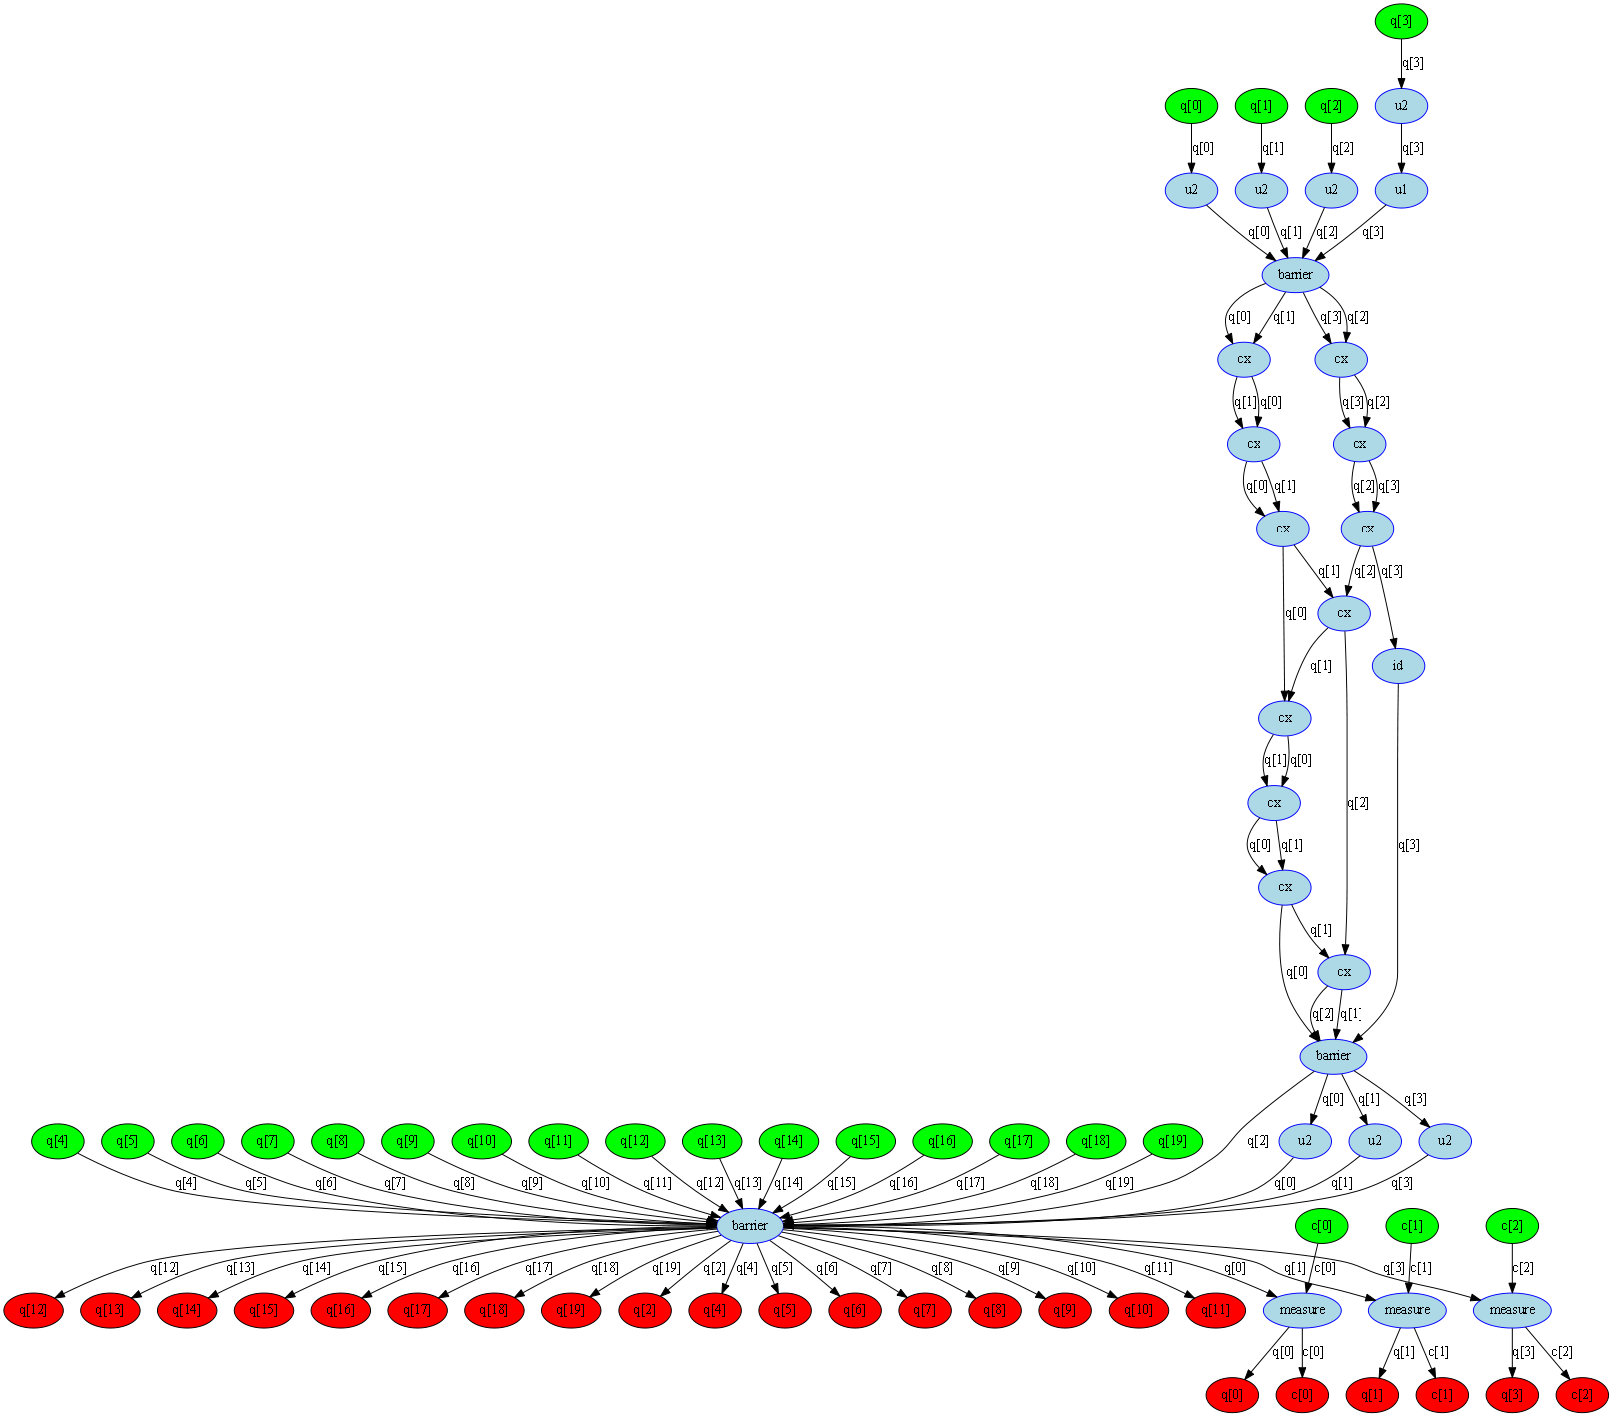

In [11]:
# Draw DAG of the transpiled circuit that used optimization_level=0
dag = circuit_to_dag(transpiled_qc0)
dag_drawer(dag)

As you can see, we have a total of 20 quantum registers because we chose `FakeBoeblingen()` as our backend, which has 20 qubits. However, this DAG does not use any quantum registers above q[3]. Feel free to define a different backend and see how the DAG differs.

Now, lets check the results when we actually run the circuit:

In [12]:
results_BV_Lev0 = simulated_backend.run(transpiled_qc0).result()

2022-06-24 18:18:01,140 --- qiskit.compiler.assembler --- INFO: Total Assembly Time - 0.00000 (ms)



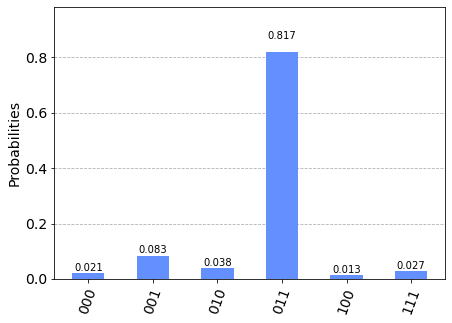

In [13]:
counts = results_BV_Lev0.get_counts()
plot_histogram(counts)
# optimization_level=0: just maps the circuit to the backend, with no explicit optimization 
# (except whatever optimizations the mapper does).

### Some Optimization

In [14]:
# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()

transpiled_qc1 = transpile(qc, simulated_backend, optimization_level=1)  # Some Optimization
print('Optimization Level 1')
print('Depth:', transpiled_qc1.depth())
print('Gate counts:', transpiled_qc1.count_ops())
transpiled_qc1.draw()

2022-06-24 18:18:01,606 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='aqc', value='qiskit.transpiler.synthesis.aqc.aqc_plugin:AQCSynthesisPlugin', group='qiskit.unitary_synthesis')

2022-06-24 18:18:01,606 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.passes.synthesis.unitary_synthesis:DefaultUnitarySynthesis', group='qiskit.unitary_synthesis')

2022-06-24 18:18:01,607 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='aqc', value='qiskit.transpiler.synthesis.aqc.aqc_plugin:AQCSynthesisPlugin', group='qiskit.unitary_synthesis')

2022-06-24 18:18:01,607 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.passes.synthesis.unitary_synthesis:DefaultUnitarySynthesis', group='qiskit.unitary_synthesis')

2022-06-24 18:18:01,609 --- qiskit.transpiler.runningpassmanager --- INFO: Pass: SetLayout - 0.00000 (ms)

2022-06-24 18:18:01,610 --- qiskit.tran

Optimization Level 1
Depth: 11
Gate counts: OrderedDict([('cx', 8), ('u2', 7), ('barrier', 3), ('measure', 3)])


┌───────────┐ ░                ┌───┐               ┌───┐ ░ »
        q_3 -> 0 ┤ U2(-π,-π) ├─░────────────────┤ X ├───────────────┤ X ├─░─»
                 └┬─────────┬┘ ░      ┌───┐     └─┬─┘     ┌───┐     └─┬─┘ ░ »
        q_2 -> 1 ─┤ U2(0,π) ├──░───■──┤ X ├──■────■────■──┤ X ├──■────■───░─»
                  ├─────────┤  ░   │  └─┬─┘  │       ┌─┴─┐└─┬─┘┌─┴─┐      ░ »
        q_1 -> 2 ─┤ U2(0,π) ├──░───┼────┼────┼───────┤ X ├──■──┤ X ├──────░─»
                  └─────────┘  ░   │    │    │       └───┘     └───┘      ░ »
  ancilla_0 -> 3 ──────────────────┼────┼────┼──────────────────────────────»
                                   │    │    │                              »
  ancilla_1 -> 4 ──────────────────┼────┼────┼──────────────────────────────»
                                   │    │    │                              »
  ancilla_2 -> 5 ──────────────────┼────┼────┼──────────────────────────────»
                  ┌─────────┐  ░ ┌─┴─┐  │  ┌─┴─┐                          ░ »
        q_0 -> 6 ─┤ U2(0,π) ├──░─┤ X ├──■──┤ X ├──────────────────────────░─»
                  └─────────┘  ░ └───┘     └───┘                          ░ »
  ancilla_3 -> 7 ───────────────────────────────────────────────────────────»
                                                                            »
  ancilla_4 -> 8 ───────────────────────────────────────────────────────────»
                                                                            »
  ancilla_5 -> 9 ───────────────────────────────────────────────────────────»
                                                                            »
 ancilla_6 -> 10 ───────────────────────────────────────────────────────────»
                                                                            »
 ancilla_7 -> 11 ───────────────────────────────────────────────────────────»
                                                                            »
 ancilla_8 -> 12 ───────────────────────────────────────────────────────────»
                                                                            »
 ancilla_9 -> 13 ───────────────────────────────────────────────────────────»
                                                                            »
ancilla_10 -> 14 ───────────────────────────────────────────────────────────»
                                                                            »
ancilla_11 -> 15 ───────────────────────────────────────────────────────────»
                                                                            »
ancilla_12 -> 16 ───────────────────────────────────────────────────────────»
                                                                            »
ancilla_13 -> 17 ───────────────────────────────────────────────────────────»
                                                                            »
ancilla_14 -> 18 ───────────────────────────────────────────────────────────»
                                                                            »
ancilla_15 -> 19 ───────────────────────────────────────────────────────────»
                                                                            »
            c: 3/═══════════════════════════════════════════════════════════»
                                                                            »
«                             ░          
«        q_3 -> 0 ────────────░──────────
«                 ┌─────────┐ ░    ┌─┐   
«        q_2 -> 1 ┤ U2(0,π) ├─░────┤M├───
«                 ├─────────┤ ░ ┌─┐└╥┘   
«        q_1 -> 2 ┤ U2(0,π) ├─░─┤M├─╫────
«                 └─────────┘ ░ └╥┘ ║    
«  ancilla_0 -> 3 ────────────░──╫──╫────
«                             ░  ║  ║    
«  ancilla_1 -> 4 ────────────░──╫──╫────
«                             ░  ║  ║    
«  ancilla_2 -> 5 ────────────░──╫──╫────
«                 ┌─────────┐ ░  ║  ║ ┌─┐
«        q_0 -> 6 ┤ U2(0,π) ├─░──╫──╫─┤M├
«                 └─────────┘ ░  ║  ║ └╥┘
«  ancilla_3 -> 7 ────────────░──

2022-06-24 18:18:02,380 --- qiskit.compiler.assembler --- INFO: Total Assembly Time - 0.00000 (ms)



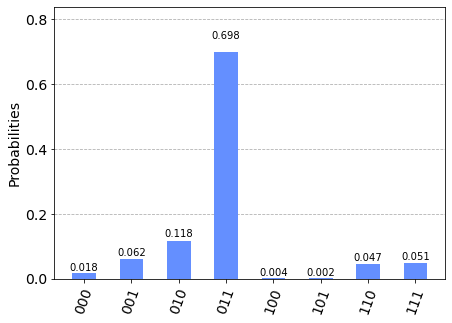

In [15]:
results_BV_Lev1 = simulated_backend.run(transpiled_qc1).result()
counts = results_BV_Lev1.get_counts()
plot_histogram(counts)
# optimization_level=1: maps the circuit, but also does light-weight optimizations by collapsing adjacent gates.

Here, we can see the correct string was identified with a higher probability than with no optimization.

2022-06-24 18:18:03,195 --- PIL.PngImagePlugin --- DEBUG: STREAM b'IHDR' 16 13

2022-06-24 18:18:03,195 --- PIL.PngImagePlugin --- DEBUG: STREAM b'bKGD' 41 6

2022-06-24 18:18:03,195 --- PIL.PngImagePlugin --- DEBUG: b'bKGD' 41 6 (unknown)

2022-06-24 18:18:03,195 --- PIL.PngImagePlugin --- DEBUG: STREAM b'IDAT' 59 8192



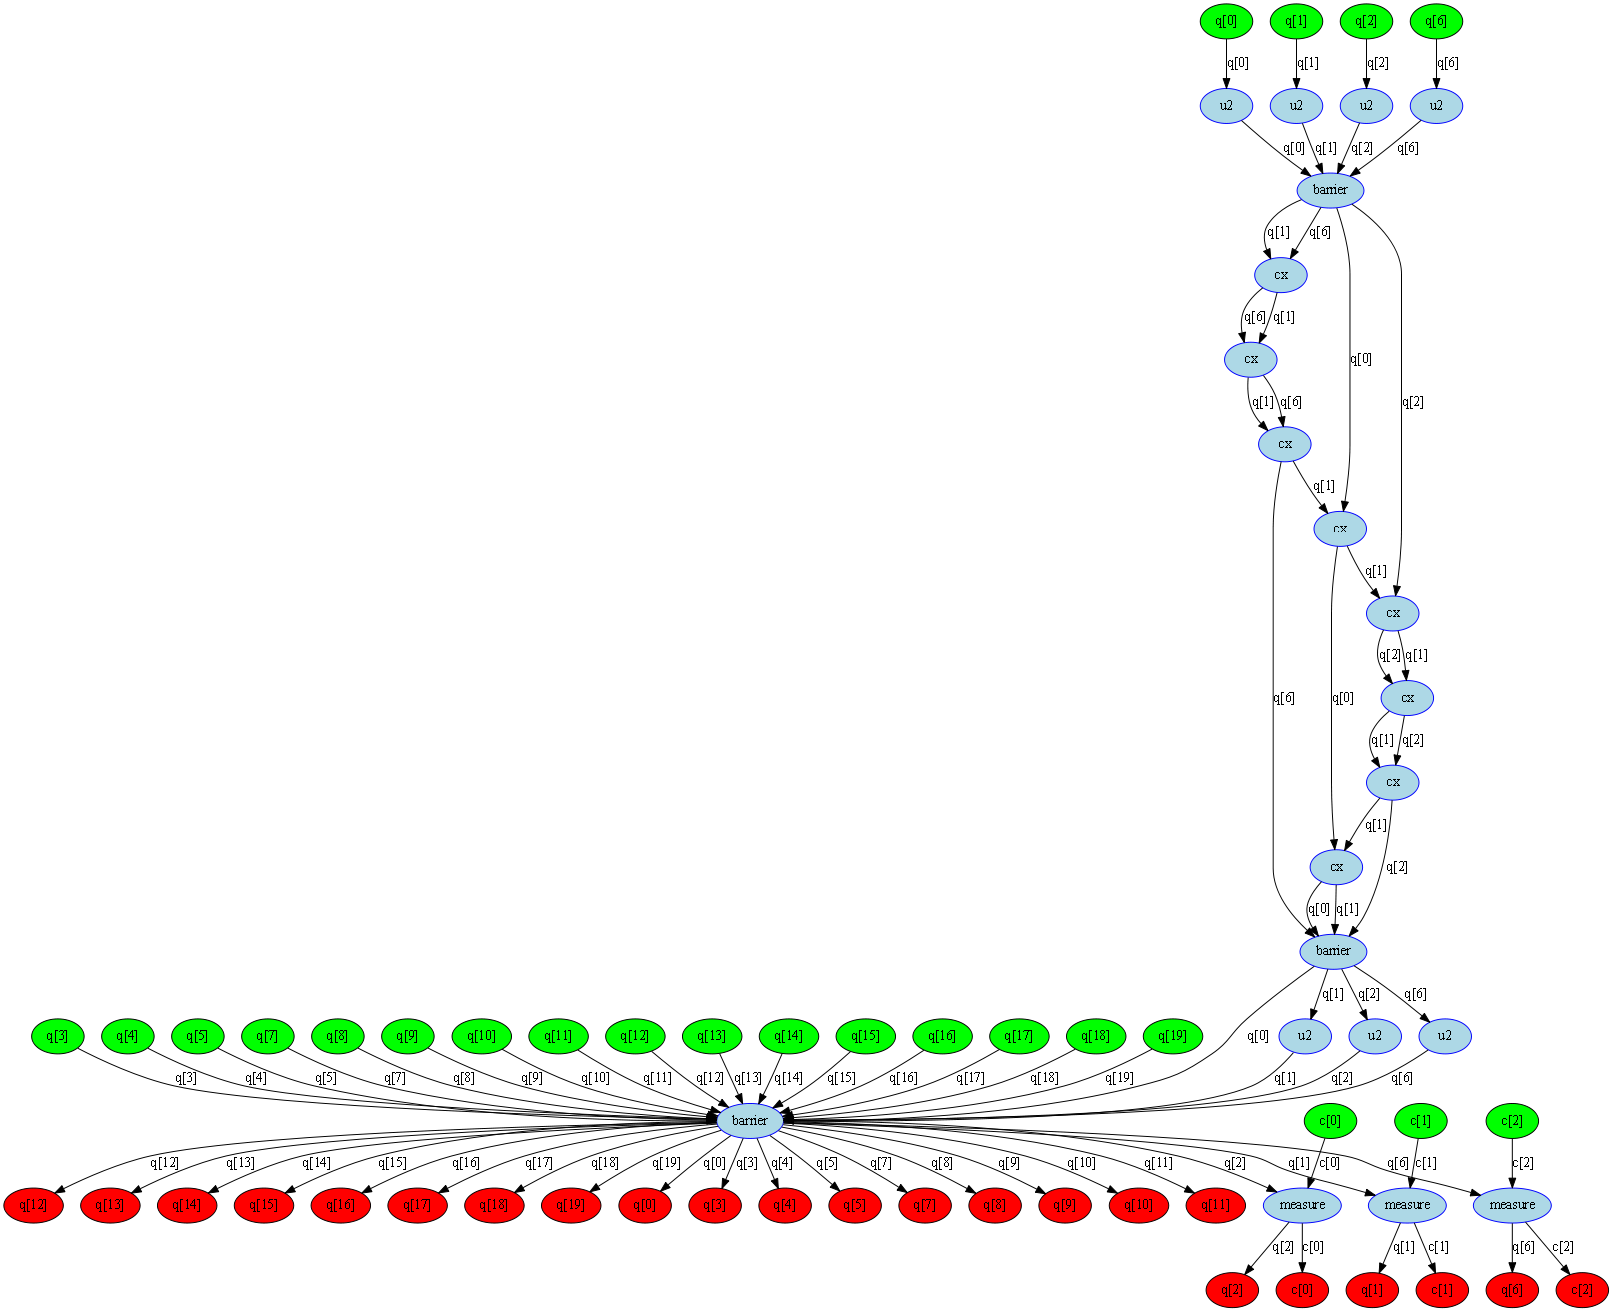

In [16]:
# Draw DAG of the transpiled circuit that used optimization_level=1
dag = circuit_to_dag(transpiled_qc1)
dag_drawer(dag)

We can visually see that the DAG is much shallower with this setting, and there are far fewer CX gates.

### More Optimization


In [17]:
# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()

transpiled_qc2 = transpile(qc, simulated_backend, optimization_level=2)  # More Optimization
print('Optimization Level 2')
print('Depth:', transpiled_qc2.depth())
print('Gate counts:', transpiled_qc2.count_ops())
transpiled_qc2.draw()

2022-06-24 18:18:03,512 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='aqc', value='qiskit.transpiler.synthesis.aqc.aqc_plugin:AQCSynthesisPlugin', group='qiskit.unitary_synthesis')

2022-06-24 18:18:03,513 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.passes.synthesis.unitary_synthesis:DefaultUnitarySynthesis', group='qiskit.unitary_synthesis')

2022-06-24 18:18:03,513 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='aqc', value='qiskit.transpiler.synthesis.aqc.aqc_plugin:AQCSynthesisPlugin', group='qiskit.unitary_synthesis')

2022-06-24 18:18:03,514 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.passes.synthesis.unitary_synthesis:DefaultUnitarySynthesis', group='qiskit.unitary_synthesis')

2022-06-24 18:18:03,516 --- qiskit.transpiler.runningpassmanager --- INFO: Pass: SetLayout - 0.00000 (ms)

2022-06-24 18:18:03,516 --- qiskit.tran

Optimization Level 2
Depth: 5
Gate counts: OrderedDict([('u2', 7), ('measure', 3), ('barrier', 2), ('cx', 2)])


ancilla_0 -> 0 ─────────────────────────────────────────────────
                                                                  
  ancilla_1 -> 1 ─────────────────────────────────────────────────
                                                                  
  ancilla_2 -> 2 ─────────────────────────────────────────────────
                                                                  
  ancilla_3 -> 3 ─────────────────────────────────────────────────
                                                                  
  ancilla_4 -> 4 ─────────────────────────────────────────────────
                  ┌─────────┐  ░            ░ ┌─────────┐      ┌─┐
        q_2 -> 5 ─┤ U2(0,π) ├──░────────────░─┤ U2(0,π) ├──────┤M├
                  └─────────┘  ░            ░ └─────────┘      └╥┘
  ancilla_5 -> 6 ───────────────────────────────────────────────╫─
                                                                ║ 
  ancilla_6 -> 7 ───────────────────────────────────────────────╫─
                                                                ║ 
  ancilla_7 -> 8 ───────────────────────────────────────────────╫─
                                                                ║ 
  ancilla_8 -> 9 ───────────────────────────────────────────────╫─
                                                                ║ 
 ancilla_9 -> 10 ───────────────────────────────────────────────╫─
                                                                ║ 
ancilla_10 -> 11 ───────────────────────────────────────────────╫─
                                                                ║ 
ancilla_11 -> 12 ───────────────────────────────────────────────╫─
                                                                ║ 
ancilla_12 -> 13 ───────────────────────────────────────────────╫─
                                                                ║ 
ancilla_13 -> 14 ───────────────────────────────────────────────╫─
                                                                ║ 
ancilla_14 -> 15 ───────────────────────────────────────────────╫─
                  ┌─────────┐  ░            ░ ┌─────────┐┌─┐    ║ 
       q_0 -> 16 ─┤ U2(0,π) ├──░───■────────░─┤ U2(0,π) ├┤M├────╫─
                 ┌┴─────────┴┐ ░ ┌─┴─┐┌───┐ ░ └─────────┘└╥┘    ║ 
       q_3 -> 17 ┤ U2(-π,-π) ├─░─┤ X ├┤ X ├─░─────────────╫─────╫─
                 └┬─────────┬┘ ░ └───┘└─┬─┘ ░ ┌─────────┐ ║ ┌─┐ ║ 
       q_1 -> 18 ─┤ U2(0,π) ├──░────────■───░─┤ U2(0,π) ├─╫─┤M├─╫─
                  └─────────┘  ░            ░ └─────────┘ ║ └╥┘ ║ 
ancilla_15 -> 19 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
            c: 3/═════════════════════════════════════════╩══╩══╩═
                                                          0  1  2

2022-06-24 18:18:04,301 --- qiskit.compiler.assembler --- INFO: Total Assembly Time - 0.99635 (ms)



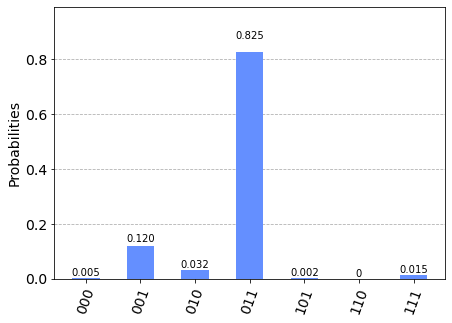

In [18]:
results_BV_Lev2 = simulated_backend.run(transpiled_qc2).result()
counts = results_BV_Lev2.get_counts()
plot_histogram(counts)
# optimization_level=2: medium-weight optimization, including a noise-adaptive layout 
# and a gate-cancellation procedure based on gate commutation relationships.

2022-06-24 18:18:04,960 --- PIL.PngImagePlugin --- DEBUG: STREAM b'IHDR' 16 13

2022-06-24 18:18:04,960 --- PIL.PngImagePlugin --- DEBUG: STREAM b'bKGD' 41 6

2022-06-24 18:18:04,960 --- PIL.PngImagePlugin --- DEBUG: b'bKGD' 41 6 (unknown)

2022-06-24 18:18:04,960 --- PIL.PngImagePlugin --- DEBUG: STREAM b'IDAT' 59 8192



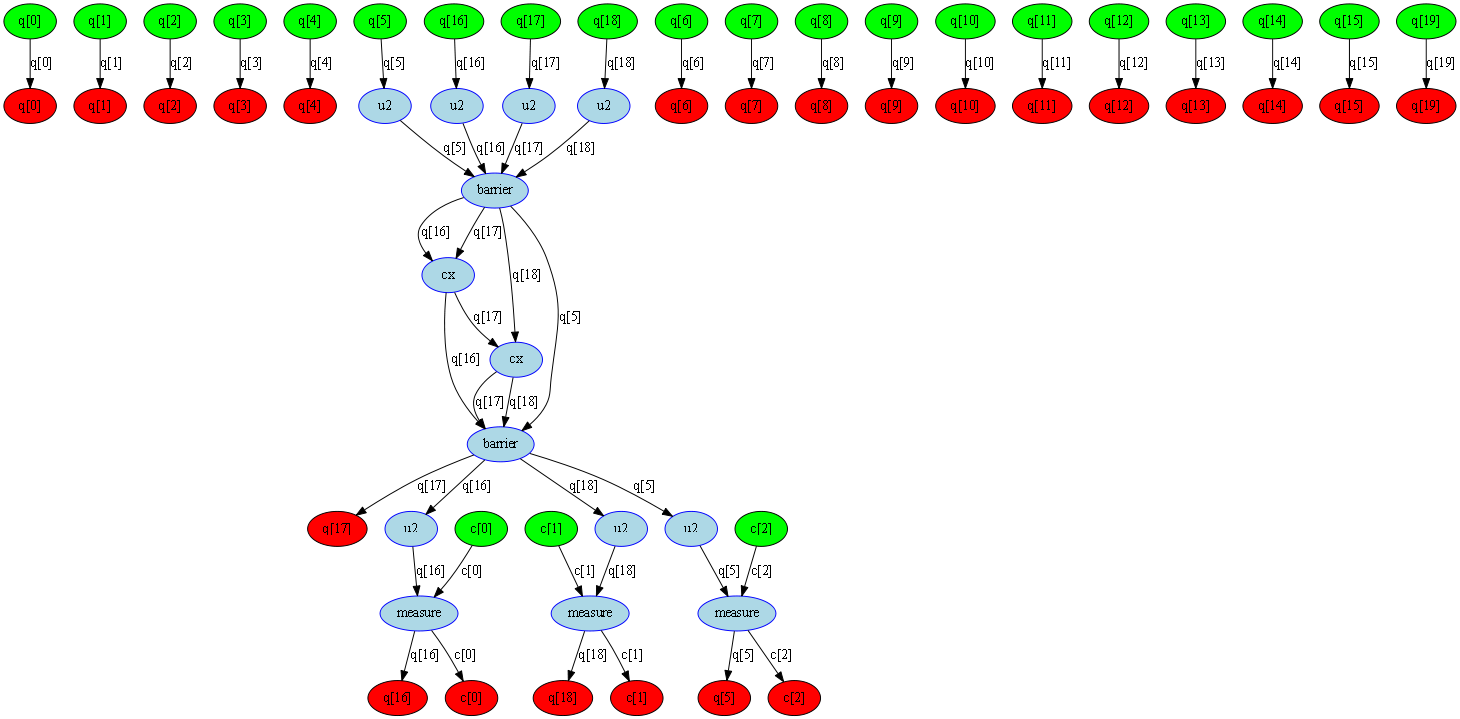

In [19]:
# Draw DAG of the transpiled circuit that used optimization_level=2
dag = circuit_to_dag(transpiled_qc2)
dag_drawer(dag)

Because this isn't such a complicated algorithm, there isn't all that much the transpiler can do. While the entire structure of the DAG changed between `optimization_level = 0` and `1`, it stays mostly the same here. However, the qubits which were chosen changed - note here its 3, 4, 8, and 15. This could be an optimization choice due to connectivity constraints.

### Max Optimization

In [20]:
# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()

transpiled_qc3 = transpile(qc, simulated_backend, optimization_level=3)  # MAXIMUM Optimization!!!
print('Optimization Level 3')
print('Depth:', transpiled_qc3.depth())
print('Gate counts:', transpiled_qc3.count_ops())
transpiled_qc3.draw()

2022-06-24 18:18:05,239 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='aqc', value='qiskit.transpiler.synthesis.aqc.aqc_plugin:AQCSynthesisPlugin', group='qiskit.unitary_synthesis')

2022-06-24 18:18:05,240 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.passes.synthesis.unitary_synthesis:DefaultUnitarySynthesis', group='qiskit.unitary_synthesis')

2022-06-24 18:18:05,241 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='aqc', value='qiskit.transpiler.synthesis.aqc.aqc_plugin:AQCSynthesisPlugin', group='qiskit.unitary_synthesis')

2022-06-24 18:18:05,241 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.passes.synthesis.unitary_synthesis:DefaultUnitarySynthesis', group='qiskit.unitary_synthesis')

2022-06-24 18:18:05,245 --- qiskit.quantum_info.synthesis.two_qubit_decompose --- DEBUG: Requested fidelity: None calculated fidelity: 1.0 actual 

2022-06-24 18:18:05,274 --- qiskit.transpiler.runningpassmanager --- INFO: Pass: Collect2qBlocks - 0.00000 (ms)

2022-06-24 18:18:05,276 --- qiskit.transpiler.runningpassmanager --- INFO: Pass: ConsolidateBlocks - 1.99366 (ms)

2022-06-24 18:18:05,276 --- qiskit.transpiler.runningpassmanager --- INFO: Pass: UnitarySynthesis - 0.00000 (ms)

2022-06-24 18:18:05,277 --- qiskit.transpiler.runningpassmanager --- INFO: Pass: Optimize1qGatesDecomposition - 0.99611 (ms)

2022-06-24 18:18:05,278 --- qiskit.transpiler.runningpassmanager --- INFO: Pass: CommutationAnalysis - 0.99754 (ms)

2022-06-24 18:18:05,278 --- qiskit.transpiler.runningpassmanager --- INFO: Pass: CommutativeCancellation - 0.00000 (ms)

2022-06-24 18:18:05,278 --- qiskit.transpiler.runningpassmanager --- INFO: Pass: UnitarySynthesis - 0.00000 (ms)

2022-06-24 18:18:05,279 --- qiskit.transpiler.runningpassmanager --- INFO: Pass: UnrollCustomDefinitions - 0.00000 (ms)

2022-06-24 18:18:05,279 --- qiskit.transpiler.passes.basis.

Optimization Level 3
Depth: 5
Gate counts: OrderedDict([('u2', 7), ('measure', 3), ('barrier', 2), ('cx', 2)])


ancilla_0 -> 0 ─────────────────────────────────────────────────
                                                                  
  ancilla_1 -> 1 ─────────────────────────────────────────────────
                                                                  
  ancilla_2 -> 2 ─────────────────────────────────────────────────
                                                                  
  ancilla_3 -> 3 ─────────────────────────────────────────────────
                                                                  
  ancilla_4 -> 4 ─────────────────────────────────────────────────
                                                                  
  ancilla_5 -> 5 ─────────────────────────────────────────────────
                                                                  
  ancilla_6 -> 6 ─────────────────────────────────────────────────
                                                                  
  ancilla_7 -> 7 ─────────────────────────────────────────────────
                  ┌─────────┐  ░            ░ ┌─────────┐   ┌─┐   
        q_1 -> 8 ─┤ U2(0,π) ├──░────────■───░─┤ U2(0,π) ├───┤M├───
                 ┌┴─────────┴┐ ░ ┌───┐┌─┴─┐ ░ └─────────┘   └╥┘   
        q_3 -> 9 ┤ U2(-π,-π) ├─░─┤ X ├┤ X ├─░────────────────╫────
                 └───────────┘ ░ └─┬─┘└───┘ ░                ║    
 ancilla_8 -> 10 ──────────────────┼─────────────────────────╫────
                                   │                         ║    
 ancilla_9 -> 11 ──────────────────┼─────────────────────────╫────
                                   │                         ║    
ancilla_10 -> 12 ──────────────────┼─────────────────────────╫────
                                   │                         ║    
ancilla_11 -> 13 ──────────────────┼─────────────────────────╫────
                  ┌─────────┐  ░   │        ░ ┌─────────┐┌─┐ ║    
       q_0 -> 14 ─┤ U2(0,π) ├──░───■────────░─┤ U2(0,π) ├┤M├─╫────
                  └─────────┘  ░            ░ └─────────┘└╥┘ ║    
ancilla_12 -> 15 ─────────────────────────────────────────╫──╫────
                                                          ║  ║    
ancilla_13 -> 16 ─────────────────────────────────────────╫──╫────
                  ┌─────────┐  ░            ░ ┌─────────┐ ║  ║ ┌─┐
       q_2 -> 17 ─┤ U2(0,π) ├──░────────────░─┤ U2(0,π) ├─╫──╫─┤M├
                  └─────────┘  ░            ░ └─────────┘ ║  ║ └╥┘
ancilla_14 -> 18 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
ancilla_15 -> 19 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
            c: 3/═════════════════════════════════════════╩══╩══╩═
                                                          0  1  2

2022-06-24 18:18:06,069 --- qiskit.compiler.assembler --- INFO: Total Assembly Time - 0.11635 (ms)



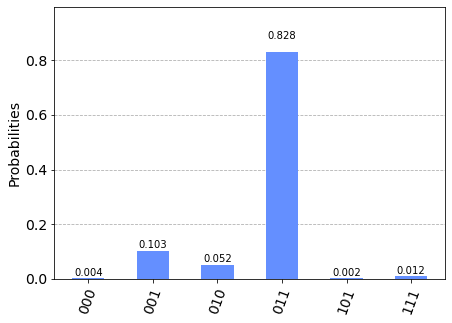

In [21]:
results_BV_Lev3 = simulated_backend.run(transpiled_qc3).result()
counts = results_BV_Lev3.get_counts()
plot_histogram(counts)
# optimization_level=3: heavy-weight optimization, which in addition 
# to previous steps, does resynthesis of two-qubit blocks of gates in the circuit.

2022-06-24 18:18:06,765 --- PIL.PngImagePlugin --- DEBUG: STREAM b'IHDR' 16 13

2022-06-24 18:18:06,766 --- PIL.PngImagePlugin --- DEBUG: STREAM b'bKGD' 41 6

2022-06-24 18:18:06,766 --- PIL.PngImagePlugin --- DEBUG: b'bKGD' 41 6 (unknown)

2022-06-24 18:18:06,767 --- PIL.PngImagePlugin --- DEBUG: STREAM b'IDAT' 59 8192



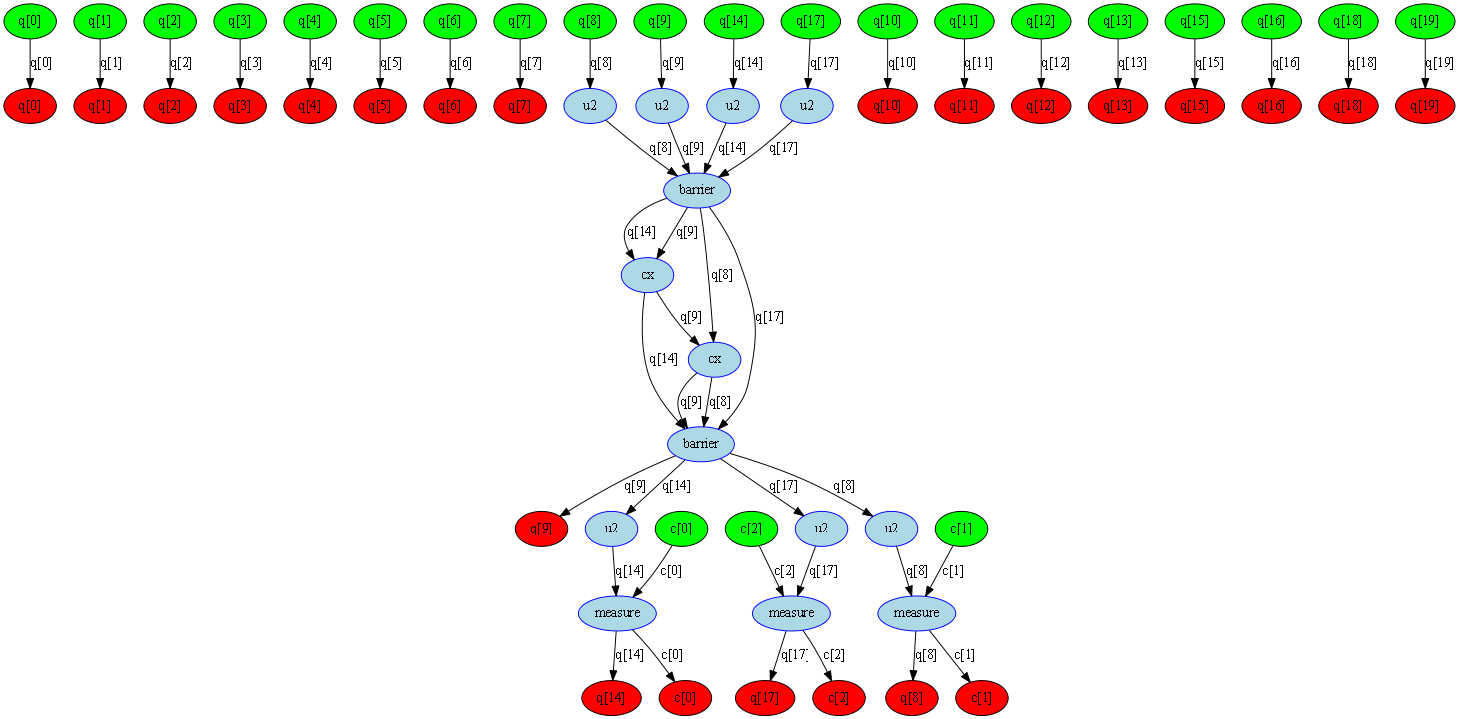

In [22]:
# Draw DAG of the transpiled circuit that used optimization_level=3
dag = circuit_to_dag(transpiled_qc3)
dag_drawer(dag)

As you can see, this DAG of the transpiled circuit is reduced when using higher optimization levels. Furthermore, q[0] through q[3] contains less nodes than previous DAGs which means fewer operations, and a more efficient, less noisy quantum circuit :)

### Qiskit to IR
Now that we've looked at transpilation, which optimizes a quantum circuit into a new circuit, we want to examine how we can bring this optimized circuit down into LLVM IR. We will do this via qcor, and follow the following pipeline:
```
Qiskit Circuit --> OpenQASM3 --> MLIR --> QIR / LLVM
```

In [23]:
# Qiskit Circuit  <-->  .qasm file
from qiskit import qasm3

# Qiskit -> OpenQASM3
# Print
print(qasm3.dumps(transpiled_qc3))
# Dump to file
with open("Bernstein_Vazirani.qasm", 'w+') as fp:
   qasm3.dump(transpiled_qc3, fp)

# Qiskit <- OpenQASM3 support?

# ----------------------------------------------------------------------------

# Deprecated

# Qiskit -> OpenQASM2
# transpiled_qc3.qasm(formatted=True, filename='Bernstein_Vazirani.qasm')
# Qiskit <- OpenQASM2
# new_qc = QuantumCircuit.from_qasm_file('Bernstein_Vazirani.qasm')

OPENQASM 3;
include "stdgates.inc";
bit[3] c;
u2(0, pi) $8;
u2(-pi, -pi) $9;
u2(0, pi) $14;
u2(0, pi) $17;
barrier $14, $8, $17, $9;
cx $14, $9;
cx $8, $9;
barrier $14, $8, $17, $9;
u2(0, pi) $14;
u2(0, pi) $17;
u2(0, pi) $8;
c[0] = measure $14;
c[1] = measure $8;
c[2] = measure $17;



## OpenQASM3 to LLVM IR

Here is where qcor comes in. We will not give an in depth tutorial on setting up qcor here: for resources, see [their documentation](https://qcor.readthedocs.io/en/latest/install.html). We recommend using the Docker image.

Once this is set up, we will use the `qcor-mlir-tool` to gain insight into the intermediate stages of compilation.

### MLIR and LLVM

[MLIR](https://mlir.llvm.org/) is a much broader LLVM project, and mostly out of our scope. It has a multitude of uses. For our purposese, we are interested in how it can be leveraged to compile quantum code. qcor leverages MLIR as a way to lower OpenQASM code to LLVM (technically, [QIR](https://devblogs.microsoft.com/qsharp/introducing-quantum-intermediate-representation-qir/), which adds several necessary features to LLVM for quantum programming). For information about that, see [this presentation](https://mlir.llvm.org/OpenMeetings/2021-05-27-Quantum-Classical-Compilation-with-MLIR.pdf).

We will use the `qcor-mlir-tool`. It has a flag `-emit` with three settings:
``` terminal
--emit=<value>                                       - Select the kind of output desired
    =mlir                                              -   output the MLIR dump
    =llvm                                              -   output the LLVM IR dump
    =mlir-llvm                                         -   output the MLIR LLVM Dialect dump
```
After running on our `Bernstein_Vazirani.qasm` file, we receive the following outputs: 
+ [MLIR](Bernstein_Vazirani.mlir)
+ [LLVM](Bernstein_Vazirani.ll)
+ [MLIR-LLVM](Bernstein_Vazirani-ll.mlir)

# Example 2: Trotterization
### What is Trotterization?
Please look [HERE](https://vtomole.com/blog/2019/04/07/trotter) for a thorough explanation

### Why is Trotterization important?
It is widely used to simulate non-commuting hamiltonians on quantum computers.

### Why did we choose Trotterization example for the quantum compilation process?
Trotterization has already been rigorously analyzed and is not too complicated to show its corresponding quantum circuit. Therefore, it serves as a simple, but important example. Rather than focus on the trotterization algorithm itself (already rigorously analyzed), we will focus on optimizing a trotterization quantum circuit using the Qiskit transpilation process.

### Trotterization Circuit for Hamiltonian, $\mathbf{H} = \mathbf{Z} \otimes \mathbf{Z} \otimes \mathbf{Z} \otimes \mathbf{Z}$


In [24]:
# Import all functions
import numpy as np
import scipy as sp
from qiskit import Aer
from qiskit.opflow import PauliTrotterEvolution, StateFn, PauliExpectation
from qiskit.opflow import CircuitSampler, PauliOp
from qiskit.opflow import I, X, Y, Z, Zero, One, Plus, Minus
from qiskit.circuit import Parameter

In [25]:
hamiltonian = (Z^Z^Z^Z)
evo_time = Parameter('t')
evolution_op = (evo_time*hamiltonian).exp_i()
num_time_slices = 1
trotterized_op = PauliTrotterEvolution(
                    trotter_mode='trotter',
                    reps=num_time_slices).convert(evolution_op)
trot_op_circ = trotterized_op.to_circuit()
trot_op_circ_decomp = trot_op_circ.decompose()
trot_op_circ_decomp.draw()

┌───┐┌───────────┐┌───┐          
q_0: ──────────┤ X ├┤ Rz(2.0*t) ├┤ X ├──────────
          ┌───┐└─┬─┘└───────────┘└─┬─┘┌───┐     
q_1: ─────┤ X ├──■─────────────────■──┤ X ├─────
     ┌───┐└─┬─┘                       └─┬─┘┌───┐
q_2: ┤ X ├──■───────────────────────────■──┤ X ├
     └─┬─┘                                 └─┬─┘
q_3: ──■─────────────────────────────────────■──

### Choose of Backend
Here we will be using the `FakeAthens()` backend and print out its basic information.
For more information of the backend please visit:
1) [Backend_Resource1](https://qiskit.org/documentation/stubs/qiskit.providers.models.BackendConfiguration.html#qiskit.providers.models.BackendConfiguration)

2) [Backend_Resource2](https://qiskit.org/documentation/tutorials/circuits_advanced/08_gathering_system_information.html)

In [26]:
from qiskit.test.mock import FakeAthens

# Define a simulated noisy backend
simulated_backend = FakeAthens()


# Print out basic features of this backend. Note, I am using a function found in Backend_Resource2
config = simulated_backend.configuration()
print("This backend is called {0}, and is on version {1}. \nIt has {2} qubit{3}. \nIt "
      "{4} OpenPulse programs. \nThe basis gates supported on this device are {5}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates))

This backend is called fake_athens, and is on version 1.3.13. 
It has 5 qubits. 
It supports OpenPulse programs. 
The basis gates supported on this device are ['id', 'rz', 'sx', 'x', 'cx', 'reset'].


### Optimization_level=0

In [27]:
#Optimization_Level=0
transpiled_qc0 = transpile(trot_op_circ_decomp, simulated_backend, optimization_level=0)  # No Optimization
print('Optimization Level 0')
print('Depth:', transpiled_qc0.depth())
print('Gate counts:', transpiled_qc0.count_ops())
transpiled_qc0.draw()

2022-06-24 18:18:06,926 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='aqc', value='qiskit.transpiler.synthesis.aqc.aqc_plugin:AQCSynthesisPlugin', group='qiskit.unitary_synthesis')

2022-06-24 18:18:06,927 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.passes.synthesis.unitary_synthesis:DefaultUnitarySynthesis', group='qiskit.unitary_synthesis')

2022-06-24 18:18:06,927 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='aqc', value='qiskit.transpiler.synthesis.aqc.aqc_plugin:AQCSynthesisPlugin', group='qiskit.unitary_synthesis')

2022-06-24 18:18:06,928 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.passes.synthesis.unitary_synthesis:DefaultUnitarySynthesis', group='qiskit.unitary_synthesis')

2022-06-24 18:18:06,929 --- qiskit.transpiler.runningpassmanager --- INFO: Pass: SetLayout - 0.00000 (ms)

2022-06-24 18:18:06,929 --- qiskit.tran

Optimization Level 0
Depth: 7
Gate counts: OrderedDict([('cx', 6), ('rz', 1)])


┌───┐┌───────────┐┌───┐          
      q_0 -> 0 ──────────┤ X ├┤ Rz(2.0*t) ├┤ X ├──────────
                    ┌───┐└─┬─┘└───────────┘└─┬─┘┌───┐     
      q_1 -> 1 ─────┤ X ├──■─────────────────■──┤ X ├─────
               ┌───┐└─┬─┘                       └─┬─┘┌───┐
      q_2 -> 2 ┤ X ├──■───────────────────────────■──┤ X ├
               └─┬─┘                                 └─┬─┘
      q_3 -> 3 ──■─────────────────────────────────────■──
                                                          
ancilla_0 -> 4 ───────────────────────────────────────────

2022-06-24 18:18:07,112 --- PIL.PngImagePlugin --- DEBUG: STREAM b'IHDR' 16 13

2022-06-24 18:18:07,112 --- PIL.PngImagePlugin --- DEBUG: STREAM b'bKGD' 41 6

2022-06-24 18:18:07,113 --- PIL.PngImagePlugin --- DEBUG: b'bKGD' 41 6 (unknown)

2022-06-24 18:18:07,113 --- PIL.PngImagePlugin --- DEBUG: STREAM b'IDAT' 59 8192



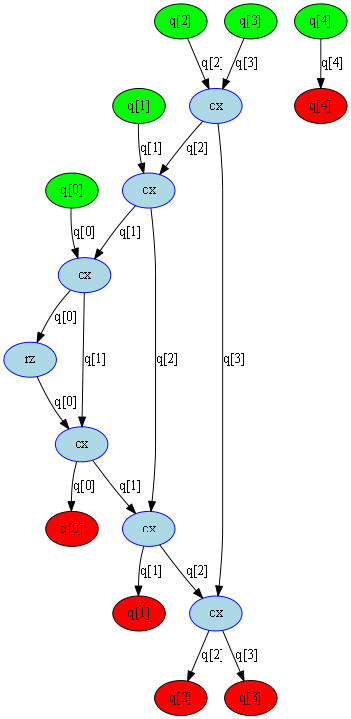

In [28]:
# Draw DAG of the transpiled circuit that used optimization_level=0
dag = circuit_to_dag(transpiled_qc0)
dag_drawer(dag)

### Optimization_level=1

In [29]:
#Optimization_Level=0
transpiled_qc1 = transpile(trot_op_circ_decomp, simulated_backend, optimization_level=1)  
print('Optimization Level 1')
print('Depth:', transpiled_qc1.depth())
print('Gate counts:', transpiled_qc1.count_ops())
transpiled_qc1.draw()

2022-06-24 18:18:07,134 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='aqc', value='qiskit.transpiler.synthesis.aqc.aqc_plugin:AQCSynthesisPlugin', group='qiskit.unitary_synthesis')

2022-06-24 18:18:07,134 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.passes.synthesis.unitary_synthesis:DefaultUnitarySynthesis', group='qiskit.unitary_synthesis')

2022-06-24 18:18:07,135 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='aqc', value='qiskit.transpiler.synthesis.aqc.aqc_plugin:AQCSynthesisPlugin', group='qiskit.unitary_synthesis')

2022-06-24 18:18:07,135 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.passes.synthesis.unitary_synthesis:DefaultUnitarySynthesis', group='qiskit.unitary_synthesis')

2022-06-24 18:18:07,137 --- qiskit.transpiler.runningpassmanager --- INFO: Pass: SetLayout - 0.00000 (ms)

2022-06-24 18:18:07,137 --- qiskit.tran

Optimization Level 1
Depth: 7
Gate counts: OrderedDict([('cx', 6), ('rz', 1)])


┌───┐┌───────────┐┌───┐          
      q_0 -> 0 ──────────┤ X ├┤ Rz(2.0*t) ├┤ X ├──────────
                    ┌───┐└─┬─┘└───────────┘└─┬─┘┌───┐     
      q_1 -> 1 ─────┤ X ├──■─────────────────■──┤ X ├─────
               ┌───┐└─┬─┘                       └─┬─┘┌───┐
      q_2 -> 2 ┤ X ├──■───────────────────────────■──┤ X ├
               └─┬─┘                                 └─┬─┘
      q_3 -> 3 ──■─────────────────────────────────────■──
                                                          
ancilla_0 -> 4 ───────────────────────────────────────────

2022-06-24 18:18:07,415 --- PIL.PngImagePlugin --- DEBUG: STREAM b'IHDR' 16 13

2022-06-24 18:18:07,415 --- PIL.PngImagePlugin --- DEBUG: STREAM b'bKGD' 41 6

2022-06-24 18:18:07,415 --- PIL.PngImagePlugin --- DEBUG: b'bKGD' 41 6 (unknown)

2022-06-24 18:18:07,415 --- PIL.PngImagePlugin --- DEBUG: STREAM b'IDAT' 59 8192



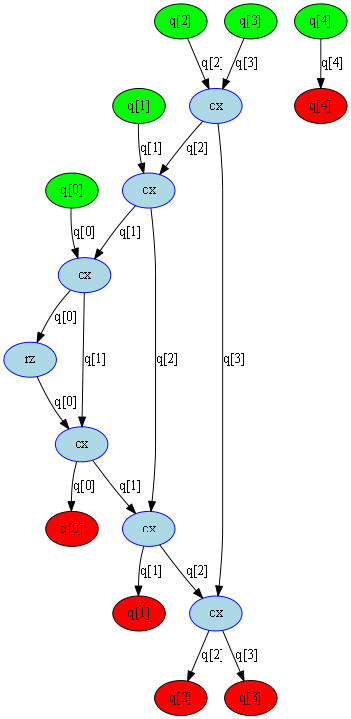

In [30]:
# Draw DAG of the transpiled circuit that used optimization_level=1
dag = circuit_to_dag(transpiled_qc1)
dag_drawer(dag)

### Optimization_level=2

In [31]:
#Optimization_Level=2
transpiled_qc2 = transpile(trot_op_circ_decomp, simulated_backend, optimization_level=2) 
print('Optimization Level 2')
print('Depth:', transpiled_qc2.depth())
print('Gate counts:', transpiled_qc2.count_ops())
transpiled_qc2.draw()

2022-06-24 18:18:07,455 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='aqc', value='qiskit.transpiler.synthesis.aqc.aqc_plugin:AQCSynthesisPlugin', group='qiskit.unitary_synthesis')

2022-06-24 18:18:07,456 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.passes.synthesis.unitary_synthesis:DefaultUnitarySynthesis', group='qiskit.unitary_synthesis')

2022-06-24 18:18:07,457 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='aqc', value='qiskit.transpiler.synthesis.aqc.aqc_plugin:AQCSynthesisPlugin', group='qiskit.unitary_synthesis')

2022-06-24 18:18:07,457 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.passes.synthesis.unitary_synthesis:DefaultUnitarySynthesis', group='qiskit.unitary_synthesis')

2022-06-24 18:18:07,460 --- qiskit.transpiler.runningpassmanager --- INFO: Pass: SetLayout - 0.00000 (ms)

2022-06-24 18:18:07,461 --- qiskit.tran

Optimization Level 2
Depth: 7
Gate counts: OrderedDict([('cx', 6), ('rz', 1)])


┌───┐┌───────────┐┌───┐          
      q_0 -> 0 ──────────┤ X ├┤ Rz(2.0*t) ├┤ X ├──────────
                    ┌───┐└─┬─┘└───────────┘└─┬─┘┌───┐     
      q_1 -> 1 ─────┤ X ├──■─────────────────■──┤ X ├─────
               ┌───┐└─┬─┘                       └─┬─┘┌───┐
      q_2 -> 2 ┤ X ├──■───────────────────────────■──┤ X ├
               └─┬─┘                                 └─┬─┘
      q_3 -> 3 ──■─────────────────────────────────────■──
                                                          
ancilla_0 -> 4 ───────────────────────────────────────────

2022-06-24 18:18:07,673 --- PIL.PngImagePlugin --- DEBUG: STREAM b'IHDR' 16 13

2022-06-24 18:18:07,674 --- PIL.PngImagePlugin --- DEBUG: STREAM b'bKGD' 41 6

2022-06-24 18:18:07,676 --- PIL.PngImagePlugin --- DEBUG: b'bKGD' 41 6 (unknown)

2022-06-24 18:18:07,676 --- PIL.PngImagePlugin --- DEBUG: STREAM b'IDAT' 59 8192



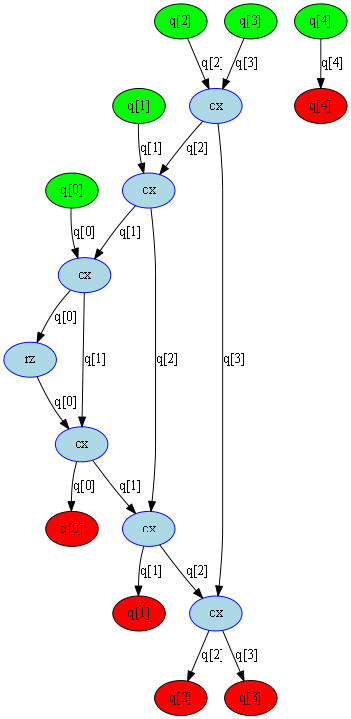

In [32]:
# Draw DAG of the transpiled circuit that used optimization_level=1
dag = circuit_to_dag(transpiled_qc2)
dag_drawer(dag)

### Optimization_level=3

In [33]:
#Optimization_Level=2
transpiled_qc3 = transpile(trot_op_circ_decomp, simulated_backend, optimization_level=3) 
print('Optimization Level 3')
print('Depth:', transpiled_qc3.depth())
print('Gate counts:', transpiled_qc3.count_ops())
transpiled_qc3.draw()

2022-06-24 18:18:07,711 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='aqc', value='qiskit.transpiler.synthesis.aqc.aqc_plugin:AQCSynthesisPlugin', group='qiskit.unitary_synthesis')

2022-06-24 18:18:07,711 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.passes.synthesis.unitary_synthesis:DefaultUnitarySynthesis', group='qiskit.unitary_synthesis')

2022-06-24 18:18:07,712 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='aqc', value='qiskit.transpiler.synthesis.aqc.aqc_plugin:AQCSynthesisPlugin', group='qiskit.unitary_synthesis')

2022-06-24 18:18:07,713 --- stevedore.extension --- DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.passes.synthesis.unitary_synthesis:DefaultUnitarySynthesis', group='qiskit.unitary_synthesis')

2022-06-24 18:18:07,717 --- qiskit.quantum_info.synthesis.two_qubit_decompose --- DEBUG: Requested fidelity: None calculated fidelity: 1.0 actual 

Optimization Level 3
Depth: 7
Gate counts: OrderedDict([('cx', 6), ('rz', 1)])


┌───┐┌───────────┐┌───┐          
      q_0 -> 0 ──────────┤ X ├┤ Rz(2.0*t) ├┤ X ├──────────
                    ┌───┐└─┬─┘└───────────┘└─┬─┘┌───┐     
      q_1 -> 1 ─────┤ X ├──■─────────────────■──┤ X ├─────
               ┌───┐└─┬─┘                       └─┬─┘┌───┐
      q_2 -> 2 ┤ X ├──■───────────────────────────■──┤ X ├
               └─┬─┘                                 └─┬─┘
      q_3 -> 3 ──■─────────────────────────────────────■──
                                                          
ancilla_0 -> 4 ───────────────────────────────────────────

2022-06-24 18:18:07,935 --- PIL.PngImagePlugin --- DEBUG: STREAM b'IHDR' 16 13

2022-06-24 18:18:07,936 --- PIL.PngImagePlugin --- DEBUG: STREAM b'bKGD' 41 6

2022-06-24 18:18:07,936 --- PIL.PngImagePlugin --- DEBUG: b'bKGD' 41 6 (unknown)

2022-06-24 18:18:07,936 --- PIL.PngImagePlugin --- DEBUG: STREAM b'IDAT' 59 8192



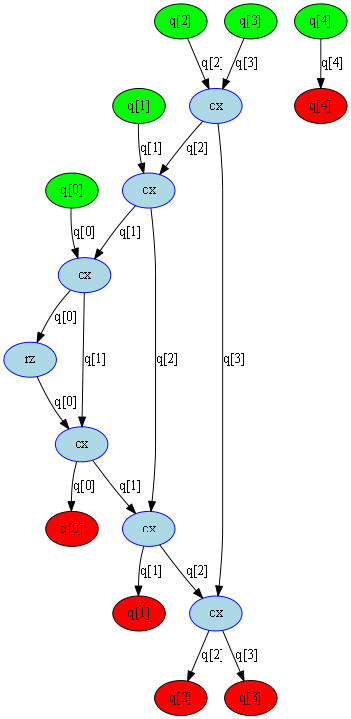

In [34]:
# Draw DAG of the transpiled circuit that used optimization_level=1
dag = circuit_to_dag(transpiled_qc3)
dag_drawer(dag)